# Spectrum Analysis

#### This piece of code does the following so far:

1. Reads spectrum data in ASCII format.

2. Finds all "peaks" in the spectrum, consistent with a given flux threshold and line width. The desired prominence of the peaks can also be adjusted, if necessary. 

3. Identifies N most significant peaks

4. Reads CASSIS line catalog.txt file for one or multiple molecule(s).

5. Compares detected peaks in the spectrum with CASSIS data to identify the lines.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig

%matplotlib qt5
plt.style.use('default')

### Obtain telescope spectrum data

In [4]:
# LOAD ASCII FILE
data = np.loadtxt("181_WSW_FTS200_3mm_average_data_Tmb.dat")
freqs = data[:,0][data[:,1]!=-1000] # FREQUENCY ARRAY 
temps = data[:,1][data[:,1]!=-1000] # TEMPERATURE ARRAY 


# UNITS
freq_units = "MHz"
flux_units = "K"

threshold = 5*5e-3 

# FIND DATA ABOVE THRESHOLD
passfreqs = freqs[temps>threshold]
passtemps = temps[temps>threshold]

# ASSUMED LINE WIDTH
width = 0.5 #(MHz)

### Find peaks

In [5]:
peaks = sig.find_peaks(temps, height=threshold, distance=2*width)[0]
peaktemps = temps[peaks]
peakfreqs = freqs[peaks]

# Save N strongest lines separately
N = 100
maxtemps = sorted(peaktemps, reverse=True)[0:N]
maxfreqs = [peakfreqs[list(peaktemps).index(i)] for i in maxtemps]

### Visualize Probable Emission Lines. This only compares the peak antenna temperature to the S/N . Many lines will be discriminated later based on their integrated intensities once a Gaussian is fit.

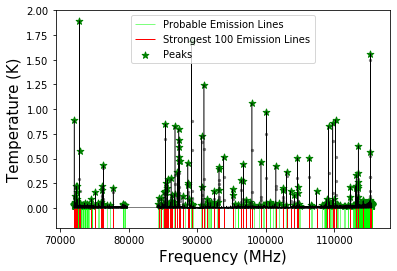

In [6]:
plt.scatter(passfreqs, passtemps, s=5, c="grey")
plt.plot(freqs[temps>0], temps[temps>0], c="black", linewidth=0.5)
plt.vlines(peakfreqs, ymin=-0.2, ymax=0, colors="lime" , linewidth=0.5, label="Probable Emission Lines")
plt.vlines(maxfreqs, ymin=-0.2, ymax=0, colors="red" , linewidth=1, label="Strongest {} Emission Lines".format(N))
plt.scatter(peakfreqs, peaktemps, s=50, c="green", marker="*", label="Peaks")

plt.xlabel("Frequency ({})".format(freq_units), fontsize=15)
plt.ylabel("Temperature ({})".format(flux_units), fontsize=15)

plt.ylim([-0.2,2])
plt.legend()

plt.show()

## Hunt for Molecules

### First, find everything that might be produced by molecules on the catalog. 

In [8]:
def hunt(catalog, catalog_file):

    # LOAD CASSIS CATALOGUE
    catalog_freqs = pd.read_csv(catalog_file, sep="\t", usecols=[2])
    catalog_freqs = catalog_freqs["Frequency(Ghz)"]
    
    catalog_names = catalog_freqs.keys()
    catalog_names = [m.split()[0] for m in catalog_names]

    detections = []
    
    # COMPARE PEAKS WITH CASSIS CATALOGUE
    for i,f1 in enumerate(catalog_freqs):
        for j,f2 in enumerate(peakfreqs):
            if abs(f1-f2) < 0.5*width:
                detections.append([catalog_names[i], f1])
                
    return detections

In [9]:
catalog = "Organics"
catalog_file = "COMsCatalog.txt"

detections = hunt(catalog, catalog_file)
            
print("Found {} probable emission lines corresponding to {}".format(len(detections), catalog))

Found 233 probable emission lines corresponding to Organics


In [10]:
fig, ax = plt.subplots(constrained_layout=True)

ax.step(freqs[temps>0], temps[temps>0], c="black", linewidth=0.5)

ax.set_ylabel("Temperature ({})".format(flux_units), fontsize=15)

ax.set_ylim([-0.2,2])

ax.vlines([d[1] for d in detections], ymin=-0.2, ymax=0, colors="blue" , linewidth=1, label="Probable Detections")



secax = ax.secondary_xaxis('top')
secax.set_xlabel("Frequency ({})".format(freq_units), fontsize=15)

ax.set_xticks([d[1] for d in detections])
ax.set_xticklabels([d[0] for d in detections], rotation=75, fontsize=10)
#plt.xticks([d[1] for d in detections], labels=[d[0] for d in detections], rotation=75, fontsize=5)
#plt.yticks([])
plt.legend()
plt.show()

### Next, count the individual molecules detected and determine how many transitions were found in the frequency range, compared to the expected lines.

In [49]:
def find_individual(detections):
    
    molecules = []
    
    for mol in detections:
        if mol[0] not in molecules:
            molecules.append(mol[0])
    
    return(molecules)
            

def count_transitions(catalog_file, frequencies, detections, molecules):
    
    # LOAD CATALOGUE
    catalog_freqs = pd.read_csv(catalog_file, sep="\t", usecols=[2])
    catalog_freqs = catalog_freqs["Frequency(Ghz)"]
    
    catalog_names = catalog_freqs.keys()
    catalog_names = [m.split()[0] for m in catalog_names]
    
    catalog = []
    for i,f1 in enumerate(catalog_freqs):
        catalog.append([catalog_names[i], f1])
    
    freq_range = [min(frequencies), max(frequencies)]
    
    transitions = []
    
    for mol in molecules:
        found = 0
        expected = 0
        
        # COUNT TRANSITIONS FOUND IN SPECTRA
        for line in detections:
            if mol == line[0]:
                found+=1
                
        # COUNT TOTAL EXPECTED TRANSITIONS IN FREQUENCY RANGE
        for cat_line in catalog:
            if mol == cat_line[0] and freq_range[0] < cat_line[1] < freq_range[1]:
                expected+=1
                
        transitions.append([mol, found, expected])  
    
    return transitions
    

In [50]:
molecules = find_individual(detections)

In [51]:
print("There are at most {} different molecules in the spectrum".format(len(molecules)))
print(molecules)

There are at most 35 different molecules in the spectrum
['DCO+', 'HC7N', 'C2H3CN', 'CH3COOH,', 'C3H7CN', 'CCS', 'CH3COCH3', 'HC3N,', 'OCS', 'C2H5OH,v=0', 'CH3CN', 'HC5N,', 'CCCS', 'C4H', 'CH3CHO', 'CH3OH,', 'HCS+', 'SO', 'CH3C3N', 'HNCO', 'HCN', 'HCO+', 'HNC', 'CH3NH2', 'CS', 'CH2CO', 'H2CS', 'l-C3H2', 'C2H5CN', 'CO-17', 'CH3OCHO', 'CN,', 'C2H3CHO', 'CH3OCH3', 'C6H']


In [62]:
transitions = count_transitions(catalog_file, freqs, detections, molecules)
for mol in transitions:
    print("{}\nEXPECTED {} LINES\tFOUND {} LINES\n".format(mol[0], mol[2], mol[1]))

DCO+
EXPECTED 2 LINES	FOUND 2 LINES

HC7N
EXPECTED 100 LINES	FOUND 2 LINES

C2H3CN
EXPECTED 1240 LINES	FOUND 30 LINES

CH3COOH,
EXPECTED 2378 LINES	FOUND 21 LINES

C3H7CN
EXPECTED 876 LINES	FOUND 10 LINES

CCS
EXPECTED 23 LINES	FOUND 13 LINES

CH3COCH3
EXPECTED 1650 LINES	FOUND 13 LINES

HC3N,
EXPECTED 8 LINES	FOUND 6 LINES

OCS
EXPECTED 7 LINES	FOUND 5 LINES

C2H5OH,v=0
EXPECTED 567 LINES	FOUND 3 LINES

CH3CN
EXPECTED 23 LINES	FOUND 10 LINES

HC5N,
EXPECTED 25 LINES	FOUND 4 LINES

CCCS
EXPECTED 11 LINES	FOUND 8 LINES

C4H
EXPECTED 64 LINES	FOUND 32 LINES

CH3CHO
EXPECTED 246 LINES	FOUND 8 LINES

CH3OH,
EXPECTED 68 LINES	FOUND 9 LINES

HCS+
EXPECTED 2 LINES	FOUND 2 LINES

SO
EXPECTED 5 LINES	FOUND 4 LINES

CH3C3N
EXPECTED 64 LINES	FOUND 2 LINES

HNCO
EXPECTED 9 LINES	FOUND 3 LINES

HCN
EXPECTED 6 LINES	FOUND 6 LINES

HCO+
EXPECTED 2 LINES	FOUND 2 LINES

HNC
EXPECTED 2 LINES	FOUND 2 LINES

CH3NH2
EXPECTED 166 LINES	FOUND 2 LINES

CS
EXPECTED 1 LINES	FOUND 1 LINES

CH2CO
EXPECTED 21 LINE